### **Title**: Stochastic Descent Program for the Work "Reinforcement Learning for Quantum Control". 
**Authors: Matteo Guida, Clara Eminente, Alberto Chimenti.** <br /> 
**Created on Oct 25th, 2020.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm,tnrange
from SD import stochastic_descent,correlation
from Qmodel import compute_H_and_LA, compute_fidelity_ext
import os
from pathlib import Path
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
#SD parameters.
L = 3 # number of qubits of the quantum system.
h = 4 # control field value in bang-bang protocol. 
h_list = [-h,h]
nsteps = 100 # lenght of the protocol.
exp_decay = False
metropolis = False

print("------------------------------------------PARAMETERS for SD------------------------------------------")
print("Number of qubits (L):", L)
print("Magnetic fields(h):", h)
print("Timesteps (n_steps):", nsteps)
print("\n")
print("\n")

#parameters for Fig. pag 2 ---- Calculation of fidelity and Q(T)
times_first_part=np.arange(0.1,1,0.1) 
times_second_part=np.arange(1,4.1,0.1)
times=np.concatenate([times_first_part,times_second_part])

nflip=1 # numeber of flips in SD algorithm.
iter_for_each_time = 20 # number of iteration for each fixed t.

fidelity_for_txt = []
print("------------------------------------------PARAMETERS for Plotting-------------------------------------")
print("Timegrid:", times)
print("Repetition at each timestep:", iter_for_each_time)
print("\n")

params_dict = {"L":L, "h":h, "timesteps":nsteps, "exp_decay":exp_decay, "metropolis":metropolis, "times":times, "iter_for_each_time": iter_for_each_time}
params_df = pd.DataFrame.from_dict(params_dict, orient="index")

------------------------------------------PARAMETERS for SD------------------------------------------
Number of qubits (L): 3
Magnetic fields(h): 4
Timesteps (n_steps): 100




------------------------------------------PARAMETERS for Plotting-------------------------------------
Timegrid: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4. ]
Repetition at each timestep: 20




In [3]:
# We set the ground states H at control fields hx = −2 and hx = 2 for the initial and target state.

states = compute_H_and_LA(L,1,-2)
qstart=states["eigvect"][:,0]
if (np.abs(1 - compute_fidelity_ext(qstart,qstart)) > 1e-9):
    print("Warning ---> Norm is not conserved")
    print(compute_fidelity(qstart,qstart))

states = compute_H_and_LA(L,1,2)
qtarget = states["eigvect"][:,0]
if (np.abs(1 - compute_fidelity_ext(qtarget,qtarget)) > 1e-9):
    print("Warning ---> Norm is not conserved")
    print(compute_fidelity(qtarget,qtarget))
    
start_fidelity = compute_fidelity_ext(qstart,qtarget)
print("initial fidelity:",start_fidelity)

initial fidelity: 0.09413245886788336


In [4]:
#save run parameters and date in custom named folder
custom_name_dir = "L"+str(L)+"_"+str(nflip)+"flip"
Path(custom_name_dir).mkdir(exist_ok=True)
Path(custom_name_dir+"/protocols").mkdir(exist_ok=True)

params_df.to_csv(custom_name_dir+"/parameters.csv")

intermediete_result = True

for T in tqdm(times):
    temp_fid = []
    best_prot = []
    for _ in tnrange(iter_for_each_time):

        best_protocol, fidelity = stochastic_descent(qstart=qstart, qtarget=qtarget, L=L, T=T, nsteps=nsteps, nflip=nflip, 
                        field_list = h_list, verbose = True, check_norm = True)

        temp_fid.append(fidelity[-1])      #at fixed T we will have "iter_for_each_time" evaluations of fidelity
        best_prot.append(best_protocol)    #all iter_for_each_time best protocols are stored in this variable 
                                           #and saved when new rounf over T starts
    fidelity_for_txt.append(temp_fid)      #fidelity evaluations are stored in the same "fidelity_fot_txt"
                                           #variable that will have dimension len(times)*iter_for_each_time
    best_prot = np.array([best_prot])
    with open(custom_name_dir +'/protocols/testT'+str(round(T, 2))+'.npy', 'wb') as f:
        np.save(f,best_prot)
    f.close()
    
    if intermediete_result and T !=0: #if T = 0 q cannot be computed
        data = np.load(custom_name_dir +'/protocols/testT'+str(round(T, 3))+'.npy')[0,:,:] #first dimension is redundant 
        print("Mean fidelity:", np.array(temp_fid).mean())
        print("Q value is:", correlation(data, h))
        print("\n")
        
#fidelity values are saved at the end
np.savetxt(custom_name_dir + '/fidelity_SD.txt', fidelity_for_txt, delimiter = ',',header="Matrix with as entries the values of fidelity dimension times x iterations")
times=np.insert(times,0,0)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

  2%|██                                                                                 | 1/40 [00:33<21:50, 33.60s/it]


Mean fidelity: 0.1044204333320411
Q value is: 0.02




  5%|████▏                                                                              | 2/40 [01:04<20:46, 32.79s/it]


Mean fidelity: 0.13494519419022336
Q value is: 0.037399999999999996




  8%|██████▏                                                                            | 3/40 [01:36<20:03, 32.53s/it]


Mean fidelity: 0.1840317293517893
Q value is: 0.062200000000000005




 10%|████████▎                                                                          | 4/40 [02:08<19:23, 32.33s/it]


Mean fidelity: 0.24733707817209308
Q value is: 0.1446




 12%|██████████▍                                                                        | 5/40 [02:33<17:38, 30.24s/it]


Mean fidelity: 0.31913674190459596
Q value is: 0.2586




 15%|████████████▍                                                                      | 6/40 [02:57<16:07, 28.47s/it]


Mean fidelity: 0.3957425043950649
Q value is: 0.3712




 18%|██████████████▌                                                                    | 7/40 [03:22<14:59, 27.25s/it]


Mean fidelity: 0.4738114410846145
Q value is: 0.478




 20%|████████████████▌                                                                  | 8/40 [03:44<13:40, 25.65s/it]


Mean fidelity: 0.5508172365049766
Q value is: 0.5176000000000001




 22%|██████████████████▋                                                                | 9/40 [04:07<12:48, 24.78s/it]


Mean fidelity: 0.6214959347246904
Q value is: 0.6032000000000001




 25%|████████████████████▌                                                             | 10/40 [04:28<11:51, 23.73s/it]


Mean fidelity: 0.6837145797020809
Q value is: 0.6504




 28%|██████████████████████▌                                                           | 11/40 [04:48<10:58, 22.70s/it]


Mean fidelity: 0.7325562321060965
Q value is: 0.6908000000000002




 30%|████████████████████████▌                                                         | 12/40 [05:06<09:52, 21.14s/it]


Mean fidelity: 0.7684598371786879
Q value is: 0.7336




 32%|██████████████████████████▋                                                       | 13/40 [05:21<08:43, 19.41s/it]


Mean fidelity: 0.7889196579940658
Q value is: 0.8062000000000002




 35%|████████████████████████████▋                                                     | 14/40 [05:36<07:52, 18.17s/it]


Mean fidelity: 0.7992034782734063
Q value is: 0.8572000000000002




 38%|██████████████████████████████▊                                                   | 15/40 [05:47<06:37, 15.90s/it]


Mean fidelity: 0.807367024060149
Q value is: 0.8968000000000003




 40%|████████████████████████████████▊                                                 | 16/40 [05:56<05:35, 13.96s/it]


Mean fidelity: 0.8130121769700785
Q value is: 0.9177000000000003




 42%|██████████████████████████████████▊                                               | 17/40 [06:09<05:14, 13.66s/it]


Mean fidelity: 0.8211587840688315
Q value is: 0.9392




 45%|████████████████████████████████████▉                                             | 18/40 [06:21<04:46, 13.03s/it]


Mean fidelity: 0.8303268011569994
Q value is: 0.9353




 48%|██████████████████████████████████████▉                                           | 19/40 [06:35<04:37, 13.23s/it]


Mean fidelity: 0.8403043291690706
Q value is: 0.9193000000000001




 50%|█████████████████████████████████████████                                         | 20/40 [06:48<04:23, 13.20s/it]


Mean fidelity: 0.8540267468318369
Q value is: 0.9276




0.09413245886788336


 52%|███████████████████████████████████████████                                       | 21/40 [06:59<03:59, 12.60s/it]


Mean fidelity: 0.861381075987061
Q value is: 0.9270000000000002




 55%|█████████████████████████████████████████████                                     | 22/40 [07:14<04:00, 13.36s/it]


Mean fidelity: 0.8844746286919964
Q value is: 0.8931000000000002




 57%|███████████████████████████████████████████████▏                                  | 23/40 [07:27<03:47, 13.40s/it]


Mean fidelity: 0.8824090636451981
Q value is: 0.9316999999999999




 60%|█████████████████████████████████████████████████▏                                | 24/40 [07:41<03:35, 13.47s/it]


Mean fidelity: 0.8698995640947947
Q value is: 0.9273000000000002




0.09413245886788336


 62%|███████████████████████████████████████████████████▎                              | 25/40 [07:53<03:16, 13.12s/it]


Mean fidelity: 0.9044438535734786
Q value is: 0.9111




 65%|█████████████████████████████████████████████████████▎                            | 26/40 [08:06<02:59, 12.84s/it]


Mean fidelity: 0.8925862056267844
Q value is: 0.9415000000000001




 68%|███████████████████████████████████████████████████████▎                          | 27/40 [08:17<02:40, 12.36s/it]


Mean fidelity: 0.8941778099547817
Q value is: 0.9427999999999999




0.09413245886788336


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [08:29<02:29, 12.44s/it]


Mean fidelity: 0.9186624647244848
Q value is: 0.9066000000000001




0.09413245886788336
0.09413245886788336
0.09413245886788336
0.09413245886788336


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [08:42<02:16, 12.39s/it]


Mean fidelity: 0.906132920190694
Q value is: 0.9383999999999999




0.09413245886788336


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [08:55<02:07, 12.76s/it]


Mean fidelity: 0.8776704339617718
Q value is: 0.9417




0.09413245886788336
0.09413245886788336
0.09413245886788336


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [09:07<01:51, 12.44s/it]


Mean fidelity: 0.9193325544943821
Q value is: 0.9337




0.09413245886788336
0.09413245886788336
0.09413245886788336
0.09413245886788336


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [09:21<01:42, 12.80s/it]


Mean fidelity: 0.8711335113920246
Q value is: 0.9633




0.09413245886788336
0.09413245886788336


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [09:32<01:26, 12.37s/it]


Mean fidelity: 0.8990532284792184
Q value is: 0.9560999999999998




 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [09:44<01:14, 12.39s/it]


Mean fidelity: 0.9085456631342511
Q value is: 0.9524999999999999




0.09413245886788336
0.09413245886788336


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [10:06<01:14, 14.97s/it]


Mean fidelity: 0.8861313081767541
Q value is: 0.9545000000000002




0.09413245886788336
0.09413245886788336
0.09413245886788336
0.09413245886788336
0.09413245886788336


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [10:23<01:02, 15.65s/it]


Mean fidelity: 0.8196062816112033
Q value is: 0.9465000000000001




0.09413245886788336
0.09413245886788336
0.09413245886788336


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [10:37<00:46, 15.35s/it]


Mean fidelity: 0.8107935599556008
Q value is: 0.9633




0.09413245886788336


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [10:50<00:28, 14.39s/it]


Mean fidelity: 0.8821066762516832
Q value is: 0.9548000000000002




 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [11:04<00:14, 14.29s/it]


Mean fidelity: 0.8648158190713842
Q value is: 0.9453999999999999




100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [11:19<00:00, 16.99s/it]


Mean fidelity: 0.8814015967925372
Q value is: 0.9254000000000001




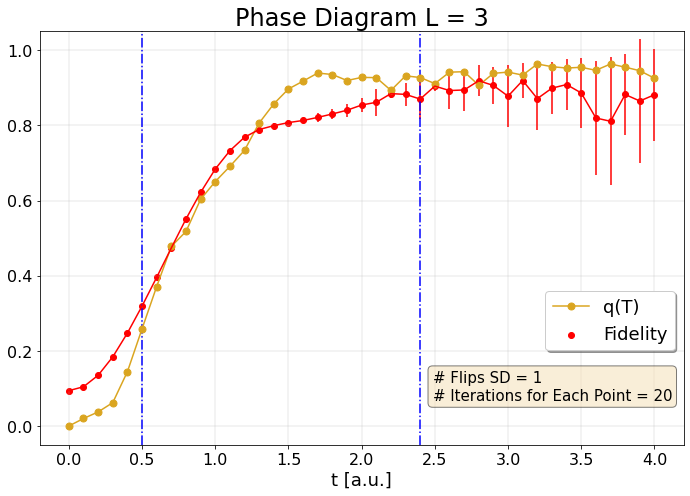

In [5]:
#PLOT 
q=[]
for T in times[1:]:
    data = np.load(custom_name_dir +"/protocols/testT"+str(round(T, 2))+".npy")[0,:,:] #first dimension is redundant 
    q.append(correlation(data,h))
    
loaded_fidelity = pd.read_csv(custom_name_dir +'/fidelity_SD.txt', skiprows=1,header=None)
mean_fidelities = loaded_fidelity.mean(axis=1).values
mean_fidelities=np.insert(mean_fidelities,0,start_fidelity)
std_fidelities = loaded_fidelity.std(axis=1).values
std_fidelities=np.insert(std_fidelities,0,0)

q.insert(0,0)
fig, ax = plt.subplots(figsize=(10,7))
#plot Fidelity values
ax.errorbar(times,mean_fidelities, yerr=std_fidelities, color="r")
ax.scatter(times,mean_fidelities,color='r',label="Fidelity")
#plot Q values
ax.plot(times, q, marker="o", color="goldenrod", markersize=7, label="q(T)")
ax.vlines(0.5,-0.05,1.05, color="b", linestyle="-.")
ax.vlines(2.4,-0.05,1.05, color="b", linestyle="-.")
ax.set_ylim(-0.05,1.05)
ax.set_title(r"Phase Diagram L = "+str(L), fontsize=24)
ax.set_xlabel("t [a.u.]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=18, loc="center right",bbox_to_anchor=(1,0.3), shadow=True)

textstr = '\n'.join((
    '# Flips SD = {:d}'
         .format(nflip),
    '# Iterations for Each Point = {:d}'
     .format(iter_for_each_time),

))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.61, 0.18, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.grid(linewidth=0.3)
fig.tight_layout()
fig.savefig(custom_name_dir+"/"+custom_name_dir+".pdf")
plt.show()